# CI data analysis: availability sequences based on a common carbon budget

In [1]:
# Import libraries:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import *
import math

from scipy import optimize
from scipy.optimize import milp

from gekko import GEKKO
from scipy.optimize import linprog
import cvxpy as cp
import copy
import numpy as np

import os
os.environ['MOSEKLM_LICENCE_FILE'] = "../../mosek"

## Introduction

**Set values for countries and dates:**

In [2]:
# Number of FL training rounds:
n_rounds = 100

# Common carbon budget
global_carbon_budget = 7 # kgCO2e

# Uniform carbon budget
carbon_budget = 1 # kgCO2eq

# list of countries/clients:
countries = ['Ireland', 'Germany', 'Great Britain', 'France', 'Sweden', 'Finland', 'Belgium']
list_colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'yellow']

**Definition of variables and useful functions:**

In [3]:
main_folder = 'figures/av-mat-2'

key_words = []
folders = []

n_clients = len(countries)

# Start and end dates:
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=n_rounds-1)

# data preparation:
_dfs = load_data()
datetime_values = get_datetime_values(_dfs, countries[0], start_date, end_date)

# initialize the similarity matrix:
time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [dt.strftime("%d %h, %H:%M") for dt in time_values]
formatted_array = [i for i in range(n_rounds)]

# functions:
def save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix):
    dict_cols = dict(zip(formatted_array, datetime_values)) # get the datetime values
    availability_matrix_to_save = availability_matrix.rename(columns=dict_cols)
    availability_matrix_to_save.to_csv('availability_matrices/av-mat-2/av-mat_'+key_word+'.csv', columns=datetime_values)

**Raw CI data:**

Let us display the raw data in between the chosen dates.

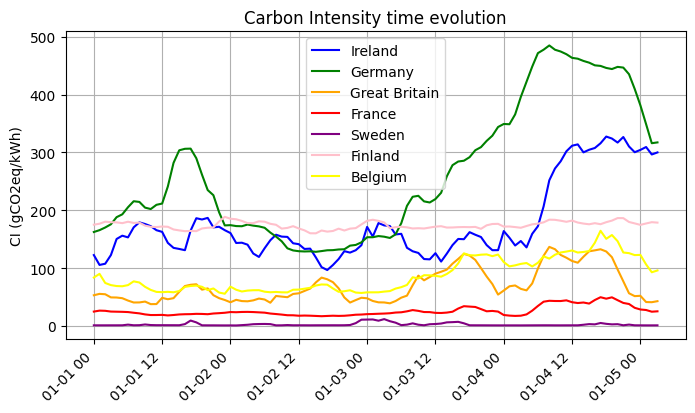

In [4]:
fig = plt.figure(figsize=(8, 4))

for country_idx, country in enumerate(countries):

    df_country = _dfs[country]
    df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

    # plot:
    plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])

    # plot legend, axis, etc.:
    # ax.set_xlim([df_to_plot['datetime'].values[0], df_to_plot['datetime'].values[-1]])
    plt.title('Carbon Intensity time evolution')
    plt.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    _ = plt.xticks(rotation=90)  
    plt.grid()
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    plt.ylabel('CI (gCO2eq/kWh)')
plt.savefig(os.path.join('figures/av-mat-2/raw_CI_data.png'), bbox_inches='tight')
plt.show()

Lets compute the mean value for each country in between these two dates, and the global mean over all countries.

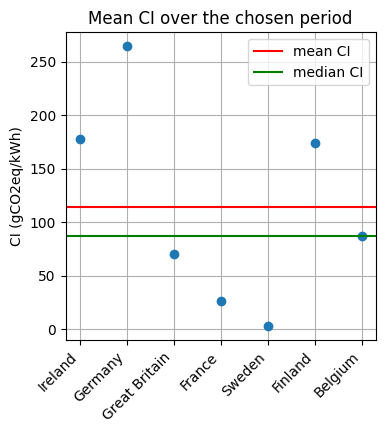

In [5]:
mean_list=[]
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    mean_list.append(CI_values.mean())
dict_countries_CI = dict(zip(countries, mean_list))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plt.plot(countries, mean_list, 'o')
plt.title('Mean CI over the chosen period')
plt.ylabel('CI (gCO2eq/kWh)')
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
plt.grid()

global_mean_CI = np.array(mean_list).mean()
ax.axhline(y=global_mean_CI, color='r', linestyle='-', label='mean CI')

median_CI = np.median(np.array(mean_list))
ax.axhline(y=median_CI, color='g', linestyle='-', label='median CI')

ax.legend()

plt.savefig('figures/av-mat-2/means.png', bbox_inches='tight')

plt.show()

**Carbon Intensity matrix:**

This matrix contains CI values in gCO2eq/kWh.

In [6]:
# initialize the similarity matrix:
# time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [i for i in range(len(time_values))]
CI_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    CI_matrix.loc[country, :] = CI_values

**GHG matrix:** 

We suppose that the power draw for all clients is constant and equal. At the moment we take the constant **300 Watts**.

The formula for carbon footprint is: power (W) * duration (hour) * carbon intensity (gCO2/kWh) * 1000

It contains the values of carbon fooprint of sustaining a certain power during ``round_duration`` hours

In [7]:
power = 300/1000 # in kiloWatts
round_duration = 1 # in hours: this is duration of a FL training round
GHG_matrix = CI_matrix * power * round_duration / 1000
GHG_mat_np = GHG_matrix.to_numpy()

We now create availability matrices. First by hand, and then using optimization algorithms.

## Uniform carbon budget 

Each country has the same carbon budget of 1 kgCO2e.

**Algorithm:**    
Each client/country is allocated the carbon budget of 1 kgCO2e. Then, the global carbon budget of the FL training is 7 kgCO2e.    
For each client, we proceed as follows:
- The client has an associated sequence of GHG values: the sequence of carbon footprint of each FL round.
- The cumulative sum of it’s sorted GHG values is used to select the FL rounds at which this client will be available. 
   
Priority is thus given to the FL rounds with the smallest GHG values so as to have as many available slots as possible.


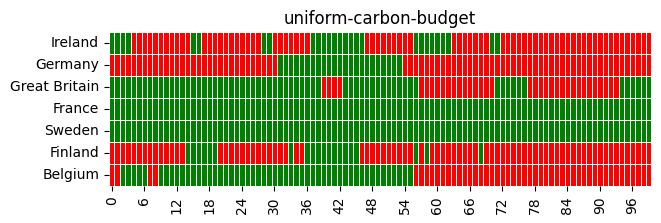

Countries lambda_2:  [0.71, 0.94, 0.87, 1.0, 1.0, 0.62, 0.92]
Mean lambda_2:  0.87


In [37]:
key_word = 'uniform-carbon-budget'
folder = main_folder+'/by_hand'

def availability_from_budget(GHG_values, budget):
    """Creates an availability sequence.
    GHG_values is an array of GHG values for one country.
    budget is this country's carbon budget in kgCO2e."""

    sorted_idx = np.argsort(GHG_values)              # indexes of GHG_values when sorted increasingly
    sorted_GHG_values = GHG_values[sorted_idx]       # GHG_values sorted increasingly
    sorted_GHG_cumsum = np.cumsum(sorted_GHG_values) # cumulative sum of GHG_values sorted increasingly

    # Select the indices in sorted index such that the cumulative sum of..
    # ..GHG_values is below the carbon budget when summing the GHG_values for these indices:
    selected_idx = sorted_idx[sorted_GHG_cumsum <= budget]

    # Creation of the availability sequence:
    availability_seq = np.zeros(len(GHG_values), dtype = np.int8)
    availability_seq[selected_idx] = 1
    availability_seq = np.array(availability_seq, dtype=bool)
    
    return availability_seq

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    GHG_values = GHG_matrix.loc[country, :].to_numpy()
    GHG_values = np.array([np.round(x, 4) for x in GHG_values])

    availability_seq = availability_from_budget(GHG_values, carbon_budget)
  
    # print(GHG_values[availability_seq].sum())

    availability_matrix.loc[country, :] = availability_seq

carb=np.sum(availability_matrix.to_numpy()*GHG_mat_np)

plot_availability_heatmap("Availability with carbon budget", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

lam2_list, corr = av_mat_corr(availability_matrix)
print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
print('Mean lambda_2: ',np.round(corr, 2))

## Uniform carbon budget and fine-tuning

Each country has the same carbon budget.

**Algorithm:**
- The last 8.5% of the training rounds are set as available for all clients to allow a final “fine-tuning” phase where all clients contribute to modifying the global model’s weights.
- For the rest of the training, the same algorithm as for the Uniform Carbon Budget availability matrix is used. However, instead of starting with a 1 kgCO2e, each client starts with the carbon budget remaining after removing the budget used for the final fine-tuning phase.

0.26043400000000005
0.06895600000000002
0.8614
0.92155
0.995848
0.567658
0.717577


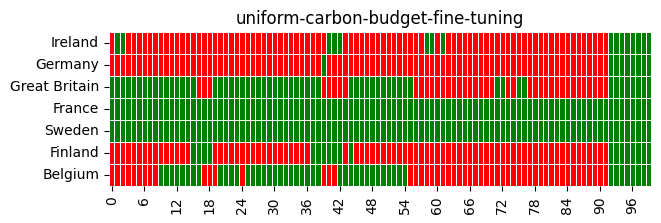

Countries lambda_2:  [0.67, 0.85, 0.79, 1.0, 1.0, 0.78, 0.82]
Mean lambda_2:  0.85


In [36]:
key_word = 'uniform-carbon-budget-fine-tuning'
folder = main_folder+'/by_hand'

percentage_fine_tuning = 0.085

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    GHG_values = GHG_matrix.loc[country, :].to_numpy()
    idx = int(percentage_fine_tuning*len(GHG_values))

    GHG_country = sum(GHG_values[-idx:])
    remaining_budget = carbon_budget - GHG_country

    print(remaining_budget)

    availability_seq = availability_from_budget(GHG_values, remaining_budget)
    availability_seq[-idx:] = 1

    availability_matrix.loc[country, :] = availability_seq

carb=np.sum(availability_matrix.to_numpy()*GHG_mat_np)

plot_availability_heatmap("Availability with carbon budget and fine-tuning", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

lam2_list, corr = av_mat_corr(availability_matrix)
print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
print('Mean lambda_2: ',np.round(corr,2))

## Uniform time budget

Here, all countries are available the same amount of time but each country is responsible for a different amount of carbon emissions.

The carbon budget is give for the ensemble of all countries.

**Algorithm:**
- Compute GHG_cumsum the GHG matrix where rows are ordered increasingly and the cumulative sum of each row is computed.
- Sum GHG_cumsum over the rows to obtain one GHG value per FL round, and select the time budget as the last index such that the value of this sequence is less than the global carbon budget.
- The matrix of indexes used to sort the rows of the GHG matrix can then be used to allocate time slots of the availability matrix.

Priority is thus given to the FL rounds with the smallest GHG values so as to have the largest time budget possible.


6.949430999999999


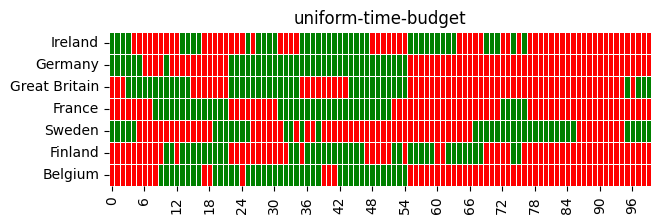

Countries lambda_2:  [0.64, 0.89, 0.81, 0.87, 0.75, 0.66, 0.83]
Mean lambda_2:  0.78


In [38]:
key_word = 'uniform-time-budget'
folder = main_folder+'/by_hand'

GHG_mat_np = GHG_matrix.to_numpy()                                      # matrix of GHG values with clients as rows and FL rounds as columns
GHG_sorted_idx = np.argsort(GHG_mat_np, axis=1)                         # matrix of indexes to sort the rows of the GHG matrix increasingly 
GHG_sorted = [GHG_mat_np[idx,l] for idx,l in enumerate(GHG_sorted_idx)] # GHG matrix with rows sorted increasingly
GHG_cumsum = np.cumsum(GHG_sorted, axis=1)                              # cumulative sum over the rows of the sorted GHG matrix
GHG_global_sum = np.sum(GHG_cumsum, axis=0)                             # sum GHG_cumsum over columns -> one value per FL round
threshold_idx = sum(GHG_global_sum < global_carbon_budget)              # select the last index such that the value of GHG_cumsum is less than the global carbon budget, this will be the time budget
availability_matrix = np.zeros(GHG_mat_np.shape, dtype = np.int8)
for idx,l in enumerate(GHG_sorted_idx):
    selected_idx = l[:threshold_idx]                                    # use GHG_sorted_idx to find the corresponding indexes to allocate in the availability matrix
    availability_matrix[idx, selected_idx] = 1

# check
print(sum(sum(np.multiply(availability_matrix,GHG_mat_np))))

carb=np.sum(availability_matrix*GHG_mat_np)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("Availability with uniform time budget and common carbon budget", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

lam2_list, corr = av_mat_corr(availability_matrix)
print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
print('Mean lambda_2: ',np.round(corr, 2))

## Uniform CI threshold

With a CI threshold any country with CI value at a given FL round smaller than the CI threshold is made available for this FL round.

**Algorithm:**    
- We first create a list of all CI values over all countries and FL rounds, ordered increasingly.
- Then, by checking each of these CI values, we find the largest CI threshold such that the global carbon budget is respected with this threshold.

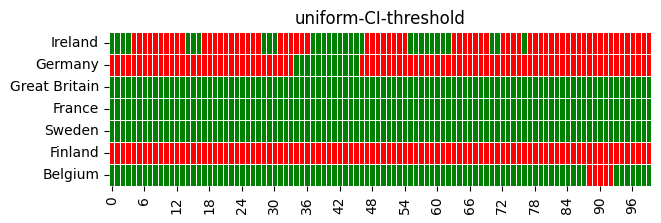

Countries lambda_2:  [0.69, 0.91, 1.0, 1.0, 1.0, 1.0, 0.79]
Mean lambda_2:  0.91


In [39]:
key_word = 'uniform-CI-threshold'
folder = main_folder+'/by_hand'

CI_mat_np = CI_matrix.to_numpy()
CI_values_sorted = np.sort(CI_mat_np, axis=None)

cpt=0
footprint=0
while footprint <= global_carbon_budget and cpt+1 < len(CI_values_sorted):
    cpt+=1
    threshold_tmp = CI_values_sorted[cpt]
    footprint = np.sum(CI_mat_np[CI_mat_np <= threshold_tmp] * power * round_duration / 1000)

threshold = CI_values_sorted[cpt-1]
availability_matrix = np.array(CI_mat_np <= threshold, dtype=np.int8)

carb=np.sum(availability_matrix*GHG_mat_np)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("Availability with uniform CI threshold and common carbon budget", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

lam2_list, corr = av_mat_corr(availability_matrix)
print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
print('Mean lambda_2: ',np.round(corr, 2))

## All Available

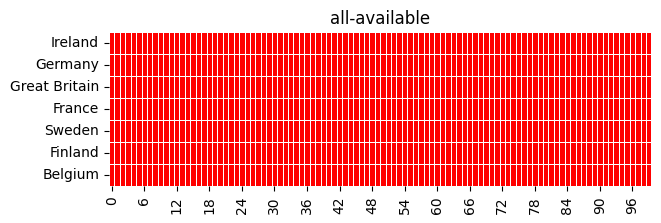

Countries lambda_2:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean lambda_2:  1.0


In [40]:
key_word = 'all-available'
folder = main_folder+'/by_hand'

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)

availability_matrix.loc[:, :] = 1

plot_availability_heatmap("Availability baseline", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

lam2_list, corr = av_mat_corr(availability_matrix)
print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
print('Mean lambda_2: ',np.round(corr, 2))

## Linear optimization

#### Simplest case

- w_c,t is constant equal to 1
- alpha (alpha faireness) is equal to 1

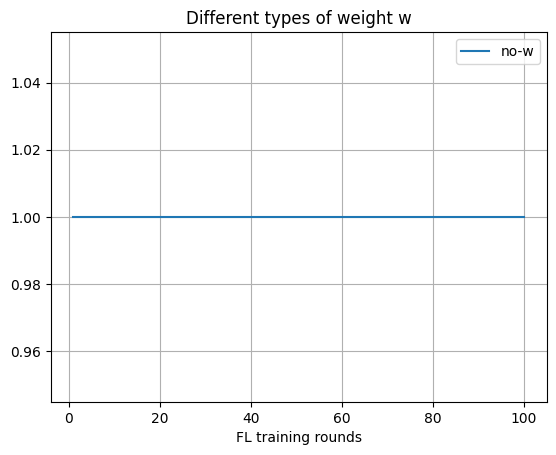

In [16]:
T_max = n_rounds # in hours

rounds_axis = np.array([i for i in range(1, n_rounds+1)])

# w_dict = {
#     'no-w': np.ones(len(rounds_axis)),
#     'linear': 1/T_max*rounds_axis,
#     'ln': 1/np.log(T_max)*np.log(rounds_axis),
#     'exp': 1/np.exp(T_max/25)*np.exp(rounds_axis/25) - 1/np.exp(T_max/25),
#     # 'exp': 1/np.exp(T_max/10)*np.exp(rounds_axis/10) - 1/np.exp(T_max/10),
#     'inverse': np.flip(1/rounds_axis)
# }

w_dict = {
    'no-w': np.ones(len(rounds_axis)),
}

plt.figure()
for key, item in w_dict.items():
    plt.plot(rounds_axis, item, label=key)
plt.legend()
plt.title('Different types of weight w')
plt.xlabel('FL training rounds')
plt.grid()
plt.savefig(main_folder+'/different_w.png', bbox_inches='tight')
plt.show()

**Method 1**: mlip

https://docs.scipy.org/doc/scipy/tutorial/optimize.html#mixed-integer-linear-programming

Objective function:  -56.74668000000002


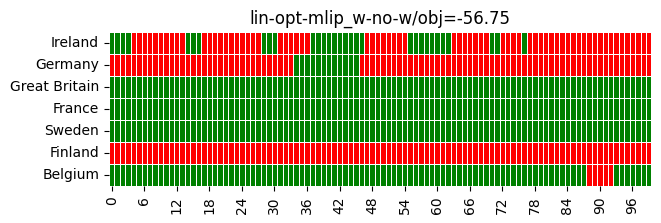

[0.68595825 0.90517241 1.         1.         1.         1.
 0.7893617 ]
0.9114989100271733


In [17]:
for choice_w in w_dict.keys():
    w = w_dict[choice_w]

    key_word = 'lin-opt-mlip'+'_w-'+choice_w
    folder = main_folder+'/optimization/linear'

    GHG_1d = GHG_matrix.to_numpy().flatten()
    tile_w = np.tile(w, GHG_matrix.shape[0])
    values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
    sizes = GHG_1d

    bounds = optimize.Bounds(0, 1)  # 0 <= x_i <= 1
    integrality = np.full_like(values, True)  # x_i are integers

    capacity = global_carbon_budget # kgCO2e
    constraints = optimize.LinearConstraint(A=sizes, lb=0, ub=capacity)


    res = milp(c=-values, constraints=constraints,
            integrality=integrality, bounds=bounds)

    print('Objective function: ', -np.dot(values, res.x))

    availability_matrix = np.array(res.x, dtype=np.int8).reshape(GHG_matrix.shape)

    # plot
    availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
    plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=-np.dot(values, res.x))
    save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

    key_words.append(key_word)
    folders.append(folder)

    lam2_list, corr = av_mat_corr(availability_matrix)
    print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
    print('Mean lambda_2: ',np.round(corr, 2))

**Method 2**: gekko

reference: https://apmonitor.com/me575/index.php/Main/PythonOptimization

Objective function:  -56.74668


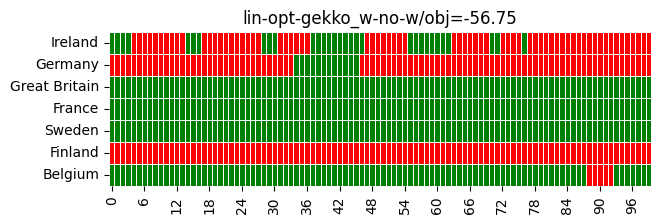

[0.68595825 0.90517241 1.         1.         1.         1.
 0.7893617 ]
0.9114989100271733


In [18]:
for choice_w in w_dict.keys():
    w = w_dict[choice_w]

    key_word = 'lin-opt-gekko'+'_w-'+choice_w
    folder = main_folder+'/optimization/linear'

    mod = GEKKO(remote=False)

    GHG_1d = GHG_matrix.to_numpy().flatten()
    tile_w = np.tile(w, GHG_matrix.shape[0])
    values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
    sizes = GHG_1d

    x = mod.Array(mod.Var,len(values),lb=0,ub=1,integer=True)

    e = [mod.Intermediate(values[i]*x[i]) for i in range(len(values))]
    mod.Minimize(-mod.sum(e))

    f = [mod.Intermediate(sizes[i]*x[i]) for i in range(len(sizes))]
    mod.Equation(mod.sum(f) <= global_carbon_budget)

    mod.options.SOLVER=1
    mod.solve(disp=False)

    #Print the results
    print("Objective function: ", mod.options.objfcnval)
    # print("Optimal solution: ", x)

    sol = [x[i][0] for i in range(len(x))]
    availability_matrix = np.array(sol, dtype=np.int8).reshape(GHG_matrix.shape)

    # plot
    availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
    plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=mod.options.objfcnval)
    save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

    key_words.append(key_word)
    folders.append(folder)
    
    lam2_list, corr = av_mat_corr(availability_matrix)
    print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
    print('Mean lambda_2: ',np.round(corr, 2))

**Method 3**: linprog

reference: https://apmonitor.com/me575/index.php/Main/PythonOptimization

Objective function:  -56.74668000000001


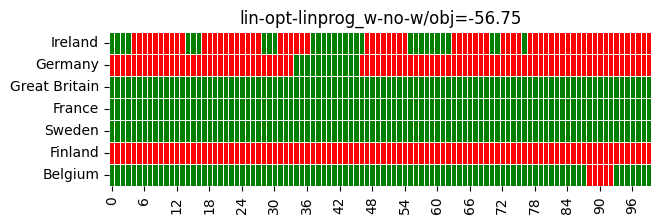

[0.68595825 0.90517241 1.         1.         1.         1.
 0.7893617 ]
0.9114989100271733


In [19]:
for choice_w in w_dict.keys():
    w = w_dict[choice_w]

    key_word = 'lin-opt-linprog'+'_w-'+choice_w
    folder = main_folder+'/optimization/linear'

    GHG_1d = GHG_matrix.to_numpy().flatten()
    tile_w = np.tile(w, GHG_matrix.shape[0])
    values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
    sizes = GHG_1d

    #Define the bounds
    b = (0, 1)

    #Solve
    res = linprog(-values, A_ub=sizes.reshape(1, len(sizes)), b_ub=global_carbon_budget, bounds=(b),
                integrality=[1 for i in range(len(values))])

    #Print the results
    print("Objective function: ", res.fun)
    # print("Optimal solution: ", res.x)

    availability_matrix = np.array(res.x, dtype=np.int8).reshape(GHG_matrix.shape)

    # plot
    availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
    plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=res.fun)
    save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

    key_words.append(key_word)
    folders.append(folder)

    lam2_list, corr = av_mat_corr(availability_matrix)
    print(lam2_list)
    print(corr)

**Method 4:** cvxpy

reference: https://www.cvxpy.org/

Restricted license - for non-production use only - expires 2025-11-24
Objective:  -56.74668


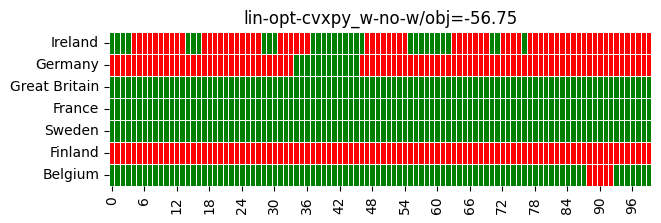

[0.68595825 0.90517241 1.         1.         1.         1.
 0.7893617 ]
0.9114989100271733


In [20]:
for choice_w in w_dict.keys():
    w = w_dict[choice_w]
    key_word = 'lin-opt-cvxpy'+'_w-'+choice_w
    folder = main_folder+'/optimization/linear'


    GHG_1d = GHG_matrix.to_numpy().flatten()
    tile_w = np.tile(w, GHG_matrix.shape[0])
    values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
    sizes = GHG_1d

    x = cp.Variable(len(GHG_1d), integer=True)
    objective = cp.Minimize(-cp.sum(cp.multiply(values, x)))
    constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(sizes, x))<=global_carbon_budget]
    prob = cp.Problem(objective, constraints)

    result = prob.solve(solver=cp.GUROBI, verbose=False)
    print('Objective: ', result)

    availability_matrix = np.array(x.value, dtype=np.int8).reshape(GHG_matrix.shape)

    # plot
    availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
    plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=result)
    save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

    key_words.append(key_word)
    folders.append(folder)

    lam2_list, corr = av_mat_corr(availability_matrix)
    print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
    print('Mean lambda_2: ',np.round(corr, 2))  

## Nonlinear Optimization

**Method 1:** greedy by hand

In [22]:
class our_problem(object):
    def __init__(self, GHG_matrix, alpha_f, w):
        self.GHG_mat = GHG_matrix.to_numpy()
        self.one_m_GHG_w = (np.max(self.GHG_mat) - self.GHG_mat)@np.diag(w)
        # self.one_m_GHG_w = (1 - self.GHG_mat/np.max(self.GHG_mat))@np.diag(w) # test
        # self.one_m_GHG_w = (np.diag(np.max(self.GHG_mat, axis=1))@np.ones((n_clients, n_rounds)) - self.GHG_mat)@np.diag(w) # test
        self.GHG_w = self.GHG_mat@np.diag(w) # test
        self.A = np.zeros(self.GHG_mat.shape)
        self.alpha_f = alpha_f
        self.n_clients = GHG_matrix.shape[0]
        self.n_rounds = GHG_matrix.shape[1]

    def obj_func(self, A):
        # remove the minus here if you want to maximize instead of minimizing (argmin -> argmax):
        return np.sum(np.power(np.sum(np.multiply(self.one_m_GHG_w, A), axis=1), self.alpha_f))
        # return np.sum(np.power(np.sum(np.multiply(self.GHG_w, A), axis=1), self.alpha_f)) # test
        # return np.sum(np.power(np.sum(np.multiply(self.GHG_w, np.ones(A.shape) - A), axis=1), self.alpha_f)) # test
    
        # return -np.sum(np.sum(np.multiply(self.one_m_GHG_w, A), axis=1))

    def diff(self, i, j):
        A_new = copy.copy(self.A)
        A_new[i, j] = 1
        # return self.obj_func(A_new) - self.obj_func(self.A)
        return (self.obj_func(A_new) - self.obj_func(self.A))/self.GHG_mat[i, j] # test
        # return self.obj_func(A_new) # something else we can optimize
    
    def update_A(self, i_star, j_star):
        self.A[i_star, j_star] = 1


def greedy_optimize(pb):
    indexes = [(i, j) for i in range(n_clients) for j in range(n_rounds)]
    mask = np.array([0 for i in range(n_clients) for j in range(n_rounds)])
    G = 7

    while True:
        values = np.array([pb.diff(*idx) for idx in indexes])

        shuf_order = np.arange(len(values))
        shuf_values = values[shuf_order]
        shuf_mask = mask[shuf_order]
        # unshuf_order = np.zeros(len(values), dtype=np.int8)
        # unshuf_order[shuf_order] = np.arange(len(values))

        masked_arr = np.ma.masked_array(shuf_values, shuf_mask)
        # shuf_res = masked_arr.argmin()
        shuf_res = masked_arr.argmax()

        res = shuf_order[shuf_res]

        i_star = res//n_rounds
        j_star = res - i_star*n_rounds

        G -= pb.GHG_mat[i_star, j_star]
        if G < 0:
            break

        pb.update_A(i_star, j_star)
        mask[res] = 1
        # indexes.remove((i_star, j_star))
    # return pb

objective: 56.746680000000005


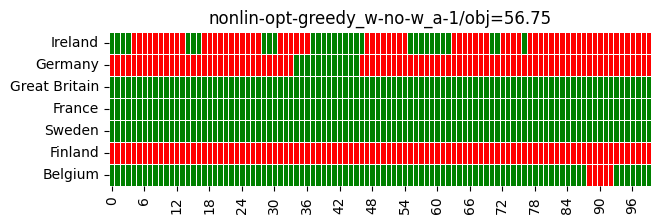

[0.68595825 0.90517241 1.         1.         1.         1.
 0.7893617 ]
0.9114989100271733
objective: 18.505872815083606


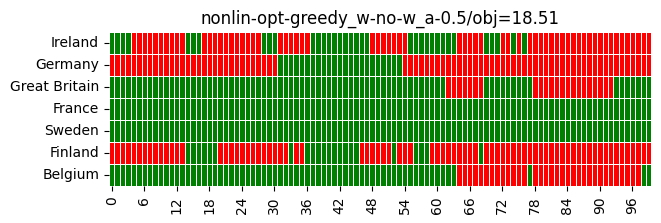

[0.66205357 0.94336384 0.88311688 1.         1.         0.64935065
 0.90909091]
0.8638536939115152
objective: 8.421109223279736


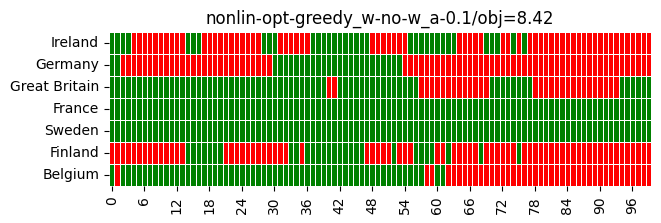

[0.66205357 0.90937829 0.85910816 1.         1.         0.60160966
 0.89915254]
0.8473288891545521


In [23]:
for choice_w in w_dict.keys():
    w = w_dict[choice_w]
    for alpha_f in [1, 0.5, 0.1]: # Choose alpha fairness coefficient
        key_word = 'nonlin-opt-greedy'+'_w-'+choice_w+'_a-'+str(alpha_f)
        folder = main_folder+'/optimization/nonlinear'

        pb = our_problem(GHG_matrix, alpha_f, w)
        greedy_optimize(pb)

        print('objective:', pb.obj_func(pb.A))

        # plot
        availability_matrix  = pd.DataFrame(pb.A, index = countries, columns = formatted_array)
        plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=pb.obj_func(pb.A))
        save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

        key_words.append(key_word)
        folders.append(folder)

        lam2_list, corr = av_mat_corr(availability_matrix)
        print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
        print('Mean lambda_2: ',np.round(corr, 2))

**Method 2:** cvxpy

Reference: https://www.cvxpy.org/

For alpha<1, this package works with the solvers MOSEK and SCIP solvers. It is slow for SCIP with 'no-w'. 

It does not work with some solvers such as Gurobi.
*Gurobi error*: SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

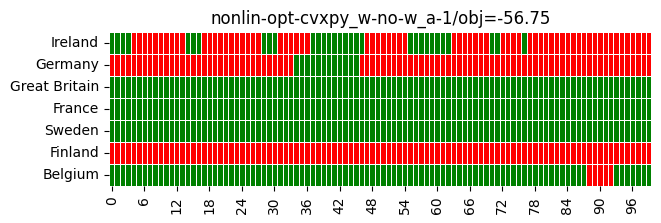

Countries lambda_2:  [0.69, 0.91, 1.0, 1.0, 1.0, 1.0, 0.79]
Mean lambda_2:  0.91


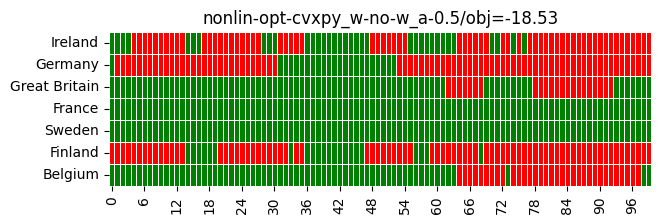

Countries lambda_2:  [0.66, 0.9, 0.88, 1.0, 1.0, 0.71, 0.91]
Mean lambda_2:  0.87


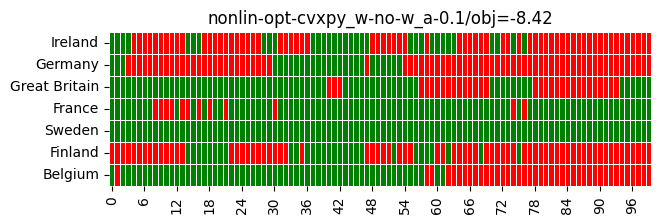

Countries lambda_2:  [0.61, 0.86, 0.86, 0.24, 1.0, 0.61, 0.9]
Mean lambda_2:  0.73


In [41]:
for choice_w in w_dict.keys():
    w = w_dict[choice_w]
    for alpha_f in [1, 0.5, 0.1]: # Change alpha here

        key_word = 'nonlin-opt-cvxpy'+'_w-'+choice_w+'_a-'+str(alpha_f)
        folder = main_folder+'/optimization/nonlinear'

        GHG_mat = GHG_matrix.to_numpy()
        one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)@np.diag(w)

        x = cp.Variable(GHG_mat.shape, integer=True)

        objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(one_m_GHG_w, x), axis=1), alpha_f)))
        # objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(GHG_w, np.ones(GHG_mat.shape) - x), axis=1), alpha_f))) # test

        constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]
        # constraints = [0 <= x[i, j] for i in range(x.shape[0]) for j in range(x.shape[1])]+[x[i, j] <= 1 for i in range(x.shape[0]) for j in range(x.shape[1])]+[cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]

        prob = cp.Problem(objective, constraints)
        # result = prob.solve(solver=cp.SCIPY, scipy_options={'method':'highs'}) # optimal objective
        # result = prob.solve(solver=cp.SCS, verbose=True, use_indirect=True) 

        result = prob.solve(solver=cp.MOSEK, verbose=False) # other solvers: SCIP (works), GUROBI (does not work for alpha<1)

        availability_matrix = np.array(x.value, dtype=np.int8)

        # plot
        availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
        plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=result)
        save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

        key_words.append(key_word)
        folders.append(folder)

        lam2_list, corr = av_mat_corr(availability_matrix)
        print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
        print('Mean lambda_2: ',np.round(corr, 2))

**Method 3:** gekko

Reference: https://apmonitor.com/me575/index.php/Main/PythonOptimization

Works for alpha=1, but NOT WORKING for alpha<1. 

Exception: @error: Solution Not Found

In [20]:
# alpha_f = 1
# key_word = 'nonlinear-optimization-gekko'+'_w-'+choice_w
# folder = main_folder+'/optimization/nonlinear'

# mod = GEKKO(remote=False)

# GHG_1d = GHG_matrix.to_numpy().flatten()
# values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
# sizes = GHG_1d

# x = mod.Array(mod.Var,len(values),lb=0,ub=1,integer=True)
# e = [mod.Intermediate(mod.sum([mod.Intermediate(values[j+i*n_rounds]*x[j+i*n_rounds]) for j in range(n_rounds)])**alpha_f) for i in range(n_clients)]
# # e = [mod.Intermediate(mod.sum([mod.Intermediate(values[j+i*n_rounds]*(1-x[j+i*n_rounds])) for j in range(n_rounds)])**alpha_f) for i in range(n_clients)] # test
# mod.Minimize(-mod.sum(e))
# # mod.Maximize(mod.sum(e)) # test

# f = [mod.Intermediate(sizes[i]*x[i]) for i in range(len(sizes))]
# mod.Equation(mod.sum(f) <= global_carbon_budget)

# mod.options.SOLVER=1
# mod.solve(disp=False)
# print("Objective function: ", mod.options.objfcnval) # print the results

# sol = [x[i][0] for i in range(len(x))] # x is the optimal solution
# availability_matrix = np.array(sol, dtype=np.int8).reshape(GHG_matrix.shape)

# # plot
# availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
# plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=mod.options.objfcnval)
# save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

# key_words.append(key_word)
# folders.append(folder)

## Second Optimization Problem

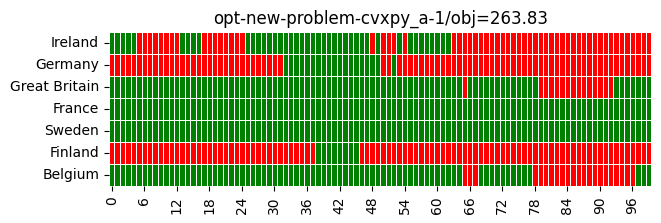

[0.76942356 0.86973684 0.84285714 1.         1.         0.86401099
 0.88311688]
0.8898779165696459


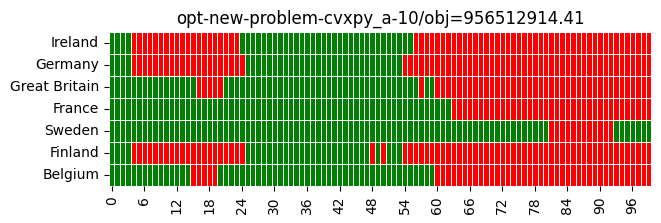

[0.92857143 0.92424242 0.9        0.98412698 0.90517241 0.82685009
 0.94090909]
0.9156960623599559


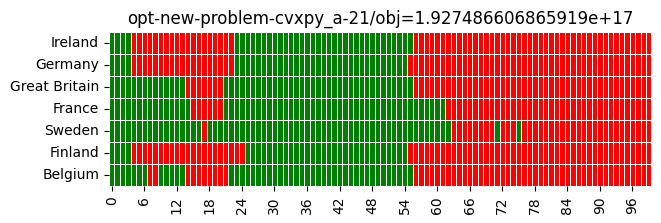

[0.92981691 0.92857143 0.93918367 0.9410299  0.85178571 0.92579186
 0.89704676]
0.9161751778841867


In [25]:
for alpha_f in [1, 10, 21]:
    key_word = 'opt-new-problem-cvxpy'+'_a-'+str(alpha_f)
    folder = main_folder

    GHG_mat = GHG_matrix.to_numpy()
    one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)

    x = cp.Variable(GHG_mat.shape, integer=True)
    objective = cp.Maximize(cp.sum(cp.multiply(cp.power(1/np.sum(GHG_mat, axis=0), alpha_f), cp.sum(cp.multiply(one_m_GHG_w, x), axis=0))))
    constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]
    prob = cp.Problem(objective, constraints)

    result = prob.solve(solver=cp.MOSEK, verbose=False)
    availability_matrix = np.array(x.value, dtype=np.int8)

    # plot
    availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
    plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=result)
    save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

    key_words.append(key_word)
    folders.append(folder)

    lam2_list, corr = av_mat_corr(availability_matrix)
    print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
    print('Mean lambda_2: ',np.round(corr, 2))

## Random availability matrix equivalents

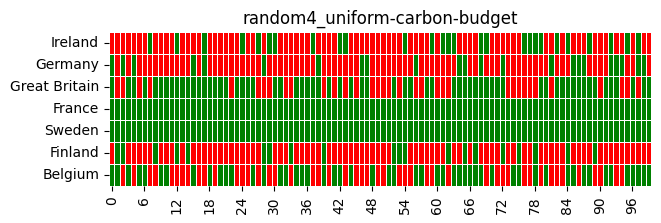

[ 0.03240741  0.10697941  0.16026786  1.          1.         -0.00253165
 -0.05147059]
0.3208074908256679


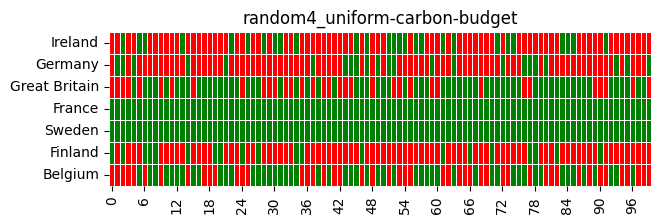

[0.08333333 0.05194805 0.1040724  1.         1.         0.07278481
 0.06833061]
0.3400670284518087


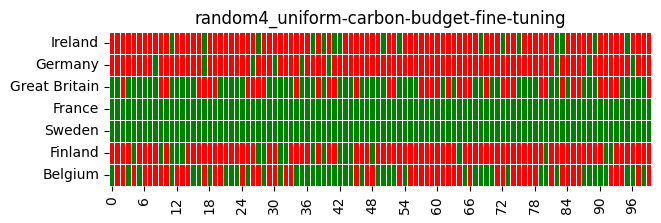

[-0.0436747  -0.1         0.22179487  1.          1.          0.21842105
  0.12806874]
0.3463728522003054


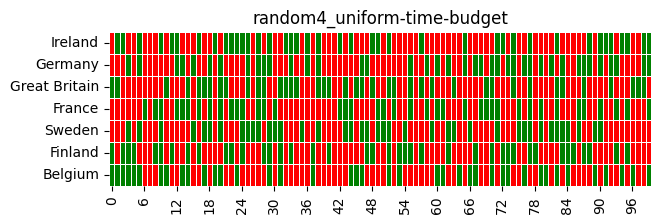

[-0.07435897 -0.15897436  0.01016949 -0.07435897  0.03516949 -0.07372881
 -0.05769231]
-0.05625349227044141


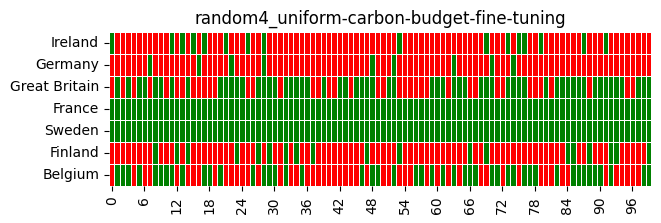

[-0.1061747  -0.1         0.13601695  1.          1.         -0.09876543
  0.00656276]
0.2625199392308952


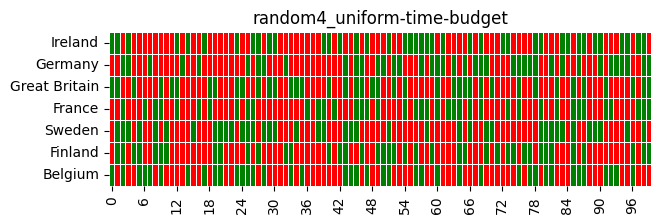

[ 0.01016949  0.0525641  -0.1        -0.07435897  0.1190678   0.01025641
  0.01016949]
0.003981188303222202


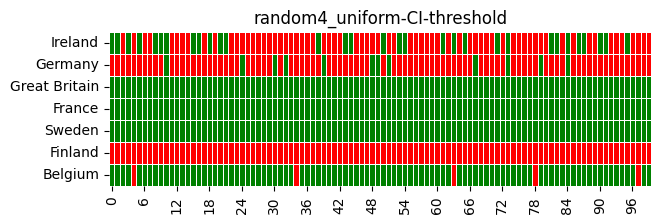

[ 0.028463   -0.04310345  1.          1.          1.          1.
 -0.05319149]
0.561738294352129


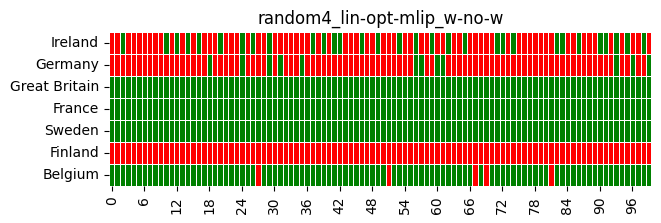

[-0.26802657  0.06818182  1.          1.          1.          1.
 -0.05319149]
0.5352805376221743


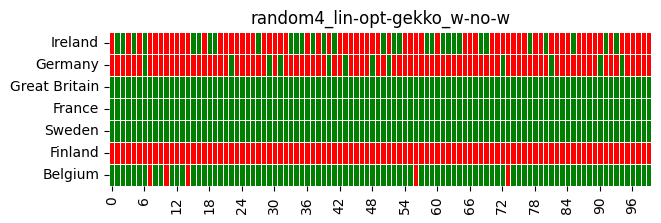

[ 0.06072106 -0.13793103  1.          1.          1.          1.
 -0.05319149]
0.5527997912534478


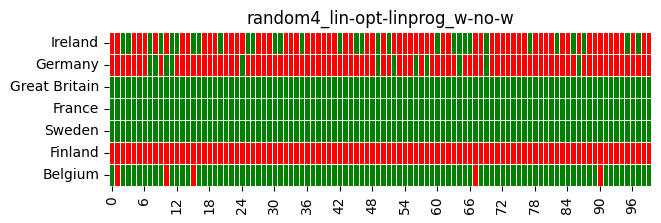

[-0.03320683  0.05172414  1.          1.          1.          1.
 -0.05319149]
0.5664751167785411


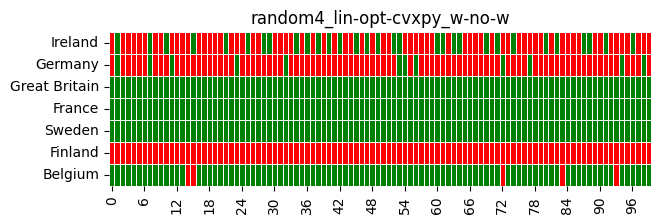

[-0.22106262 -0.04310345  1.          1.          1.          1.
  0.15744681]
0.5561829630912787


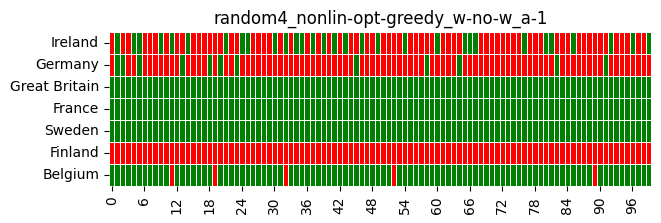

[-0.16231884 -0.04310345  1.          1.          1.          1.
 -0.05319149]
0.5344837459689608


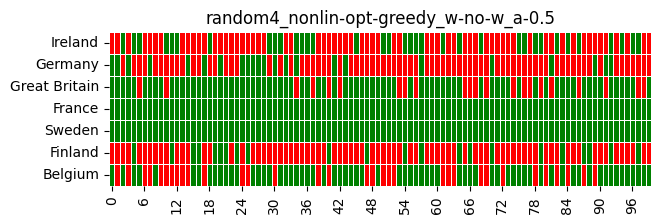

[ 0.11607143  0.05034325  0.00649351  1.          1.         -0.05194805
  0.09090909]
0.3159813176362702


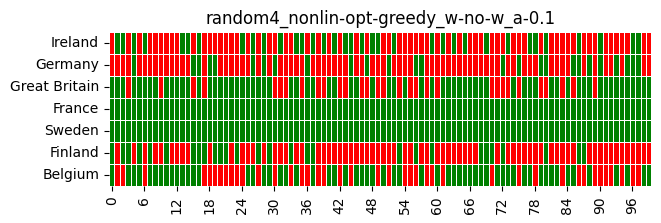

[-0.2375      0.0089568   0.06072106  1.          1.          0.06790744
  0.04247267]
0.27750828143151496


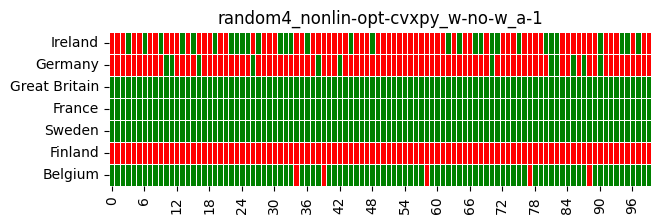

[ 0.01375712  0.05172414  1.          1.          1.          1.
 -0.05319149]
0.5731842520455511


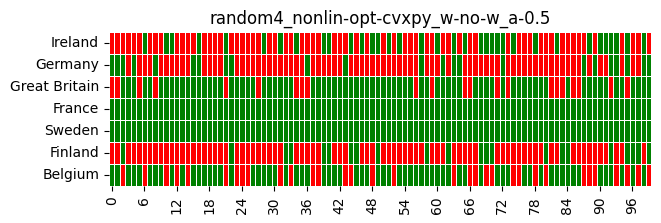

[-0.10491071  0.12337662  0.13636364  1.          1.          0.2014652
 -0.07695896]
0.3256193988136951


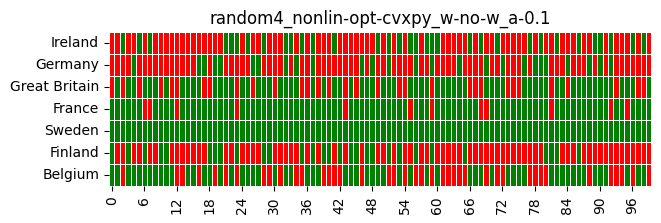

[-0.18181818 -0.09536354 -0.04710821  0.05172414  1.          0.03891626
  0.06016949]
0.11807427918166688


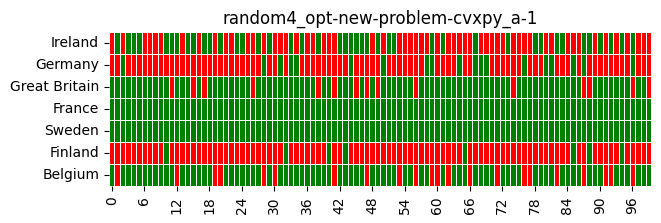

[-0.07518797  0.08815789 -0.09327731  1.          1.         -0.08791209
 -0.05194805]
0.25426178200393146


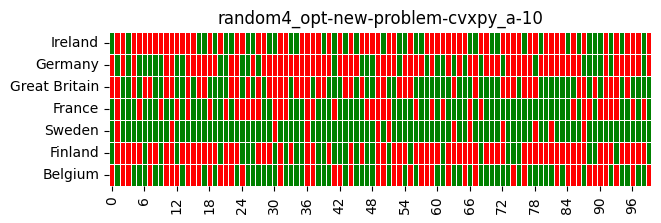

[-0.07539683  0.09090909  0.04429861  0.0505667  -0.13793103  0.04347826
 -0.06363636]
-0.006815938656433104


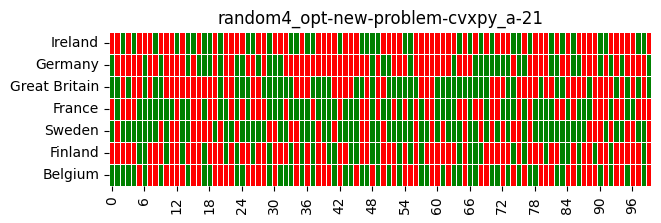

[-0.07890148  0.11607143  0.23161765 -0.06893688 -0.07633929 -0.20950226
 -0.19934372]
-0.04076207944220088


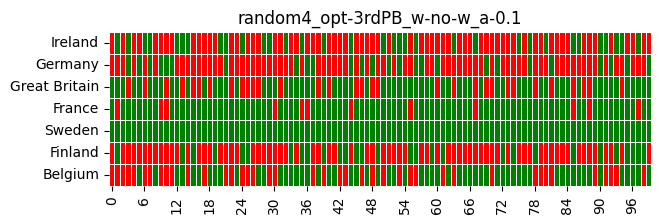

[-0.04545455 -0.1372973  -0.06203358  0.05172414  1.         -0.02413793
  0.05971405]
0.1203592610673533


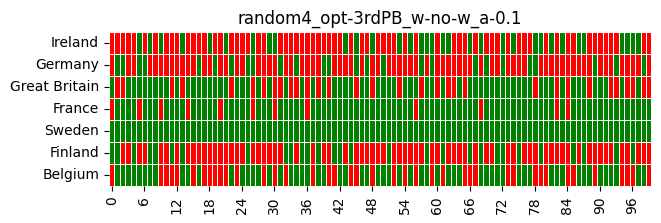

[-0.09090909 -0.09536354 -0.14184061 -0.12643678  1.         -0.10738916
  0.03516949]
0.0676043298094164


In [29]:
def create_matrix_with_zeros(num_rows, num_cols, num_zeros_per_row):
    # Create a matrix filled with ones
    matrix = np.ones((num_rows, num_cols), dtype=int)

    # Randomly set zeros in each row
    for i in range(num_rows):
        # Validate input
        if num_zeros_per_row[i] < 0 or num_zeros_per_row[i] > num_cols:
            raise ValueError("Invalid number of zeros per row.")
        indices = np.random.choice(num_cols, num_zeros_per_row[i], replace=False)
        matrix[i, indices] = 0

    return matrix

for key_word, folder in zip(key_words, folders):

    df = pd.DataFrame(pd.read_csv("availability_matrices/av-mat-2/av-mat_"+key_word+".csv", index_col=[0]))

    num_zeros_per_row = df.apply(lambda row: (row == 0).sum(), axis=1).values

    values = create_matrix_with_zeros(len(countries), len(formatted_array), num_zeros_per_row)

    # obj = np.sum(values*GHG_mat_np)

    availability_matrix  = pd.DataFrame(values, index = countries, columns = formatted_array)

    save_availability_matrix(datetime_values, formatted_array, 'random4_'+key_word, availability_matrix)
    plot_availability_heatmap("", availability_matrix, 'random4_'+key_word, folder=folder)

    lam2_list, corr = av_mat_corr(availability_matrix)
    print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
    print('Mean lambda_2: ',np.round(corr, 2))

In [25]:
random_key_words = ['random4_'+e for e in key_words]

print((' ').join(key_words) + ' ' + (' ').join(random_key_words))

uniform-carbon-budget uniform-carbon-budget-fine-tuning uniform-time-budget uniform-CI-threshold lin-opt-mlip_w-no-w lin-opt-mlip_w-linear lin-opt-mlip_w-ln lin-opt-mlip_w-exp lin-opt-mlip_w-inverse lin-opt-gekko_w-no-w lin-opt-gekko_w-linear lin-opt-gekko_w-ln lin-opt-gekko_w-exp lin-opt-gekko_w-inverse lin-opt-linprog_w-no-w lin-opt-linprog_w-linear lin-opt-linprog_w-ln lin-opt-linprog_w-exp lin-opt-linprog_w-inverse lin-opt-cvxpy_w-no-w lin-opt-cvxpy_w-linear lin-opt-cvxpy_w-ln lin-opt-cvxpy_w-exp lin-opt-cvxpy_w-inverse nonlin-opt-greedy_w-no-w_a-1 nonlin-opt-greedy_w-no-w_a-0.5 nonlin-opt-greedy_w-no-w_a-0.1 nonlin-opt-greedy_w-linear_a-1 nonlin-opt-greedy_w-linear_a-0.5 nonlin-opt-greedy_w-linear_a-0.1 nonlin-opt-greedy_w-ln_a-1 nonlin-opt-greedy_w-ln_a-0.5 nonlin-opt-greedy_w-ln_a-0.1 nonlin-opt-greedy_w-exp_a-1 nonlin-opt-greedy_w-exp_a-0.5 nonlin-opt-greedy_w-exp_a-0.1 nonlin-opt-greedy_w-inverse_a-1 nonlin-opt-greedy_w-inverse_a-0.5 nonlin-opt-greedy_w-inverse_a-0.1 nonlin-op